In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
np.random.seed(44)


In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [8.0, 3.0],
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Normal Hierarchical  Models


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on 

* Alicia A. Johnson, Miles Q. Ott, Mine Dogucu, Bayes Rules! An Introduction to Applied Bayesian Modeling, Chapter 16,  *Hierarchical Models without Predictors*, https://www.bayesrulesbook.com/chapter-16.html


# Modeling songs popularity

* Spotify  provides a data bases of songs and their *popularity* score,  which varies over  the 0-100 scale. 


* Higher popularity usually means the song has been played often, especially  recently. 

# Research questions 


*   What’s the typical popularity of a Spotify song?


*   How does popularity vary from artist to artist?


*   For any single artist, how much does popularity vary from song to song?


*  We look for answers with a quantification of the related uncertainty.

# Hierarchical data set

* The data set  comprises  one or more songs for each of the 44 artists 


* The list of artists  is a  sample from the whole population of  artists that have songs on Spotify 

<img src='img/spotify-hierarchical-data-diagram.png' width=600 align="center" >



# The structure of the data

* The $j$ subscript refers to the $j$-th  artist (we have 44 artists).

*  $n_j$: number of songs created by artist $j$.

*  $y_{ij}$:  popularity of the $i$-th song of artist $j$
    * $j \in \{1,2,…,44\}$, $i \in \{1,2,…,n_j\}$.

* The data set is constituted by  44 *sub-populations* (or *clusters*);   each artist provides a cluster of songs.

In [3]:
# the full data set is available from the bayesrule package for R. This is a reduced version which only contains song,
#author and popularity.
#The data set contains 350 songs by 44 artists
spotify = pd.read_csv("data/spotify.csv")

spotify.head()

,artist,title,popularity
0,Alok,On & On,79
1,Alok,All The Lies,56
2,Alok,Hear Me Now,75
3,Alok,The Wall,65
4,Alok,Hear Me Now,52


In [4]:
# we create a list containing the  name of each artist: ['Alok', 'Atlas Genius', 'Au/Ra', 'BUNT.', 'Beyoncé', ...]
spotify["artist"] = spotify["artist"].astype("category")
artists = list(spotify["artist"].cat.categories) 

#show the first artists
artists[0:5]

['Alok', 'Atlas Genius', 'Au/Ra', 'BUNT.', 'Beyoncé']

In [5]:
# Mean popularity of the songs of each artist, ranked from the less popular one.
artist_popularity=spotify.groupby(['artist']).mean().sort_values('popularity').head()
artist_popularity

,popularity
artist,
Mia X,13.250000
Chris Goldarg,16.400000
Soul&Roll,24.200000
Honeywagon,31.666667
Röyksopp,33.250000


In [6]:
# Number of the songs of each artists; it varies between 2 and 40.
artist_count=spotify.groupby(['artist']).count()
artist_count.head()

,title,popularity
artist,,
Alok,19,19
Atlas Genius,4,4
Au/Ra,5,5
BUNT.,3,3
Beyoncé,25,25


# Modelling approaches

* *Pooled*: merge  data from songs of all artists, without modelling the difference between artists.
     
     
* *Unpooled*:  independently analyzes the songs of every  artist
    * the mean popularity of songs from artist $j$ is $\mu_j$
    * inference about artists with  few published songs is  uncertain
    * cannot predict a novel artist

# Hierarchical model (partial pooling)

* Like the unpooled model, the mean popularity of songs from artist $j$ is  $\mu_j$   
    
       
* additionally, $\mu_j$ is assumed to be a sample from the population of artists: $ \mu_j \sim N(\mu', \sigma_p)$


* where $\mu'$ and $\sigma_p$ are the mean popularity and the std deviation of the $\mu_j$'s. These are parameters to which we will assign priors.





 

# Hierarchical model (partial pooling)

* It places a prior on the parameters of the prior (*hierarchical*).
    
       
* It can make prediction also for an artist for which there are no songs in our sample, based on what it has learned about the populations of artists. Moreover, it  improves the estimates for artists with few songs. 






# Pooled model

<img src='img/spotify-density.png' width=400 align="center" >

*  We fit a  normal-normal model  on all  songs in the sample (density  shown in the plot), ignoring the grouping structure implied by the different authors.


# Pooled model

* We fit a normal-normal model on  the data set containing all songs.
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu} ) \\
\sigma & \sim \text{HalfNormal}(\xi)\\
\vec{y_{ij}} & \sim N(\mu, \sigma)
\end{align*}

*  $\mu$ and $\sigma$ are   *global* parameters, which apply to every song.


# Prior on $\mu$

* A priori,  we assume $\mu$ to lie in  (30, 70).

* Interpreting the  interval as a region of $\pm$2 standard deviations, our prior beliefs about the mean of the population is:

$$ \mu \sim N(50, 10) $$



# Prior on $\sigma$

In [7]:
# sigma controls the spread of popularity in the whole population of songs
# We can interpret the range (0 , 100) as a range with length 4 stds (+-2 std around the mean).
# Thus a plausible value of  sigma is  25. 
#This is slightly in excess, as some density is outside the allowed range (0,100).

# Using  scale 36, we get the median of the distribution close to 25.
from scipy.stats import halfnorm 
pd.DataFrame(halfnorm.rvs(scale=36, size=10000)).describe()

,0
count,10000.000000
mean,28.907927
std,21.774580
min,0.005977
25%,11.770519
50%,24.481657
75%,41.423314
max,137.738299


# Pooled model


\begin{align*}
\mu    & \sim N(50, 10) \\
\sigma & \sim\text{HalfNormal} (36) \\
\vec{y_{ij}}  & \sim N(\mu, \sigma) \\
\end{align*}

In [8]:
with pm.Model() as pooled_model:
    # prior
    global_mean    =  pm.Normal ('global_mean', 50,  10)
    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 36)

    #likelihood
    popularity          =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])
    trace_pooled     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, global_mean]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [9]:
# The Spotify songs have an average popularity of about 58.
# There is  a  large standard deviation  (global_sigma) of popularity  from song to song,
#of about 20 points. The data set has large variability, as it contains songs from different authors. 
az.summary(trace_pooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_mean,58.308,1.114,56.199,60.326,0.018,0.013,3656.0,2610.0,1.0
global_sigma,20.726,0.809,19.307,22.325,0.014,0.010,3556.0,2772.0,1.0


# Quiz yourself

* How would you make  a prediction using the  pooled model for:

    * a new song of  Mia X, the artist with the lowest mean popularity  (13) in the sample? 
    * Beyoncé, the artist with the highest mean popularity (70) in the sample?
    * a group not present in the sample?
   

# Answer
* The  complete pooled model ignores the artist; the prediction is the same  for any new song, be it a known or unknown artist.

# Predicting the popularity of the next song (*predictive distribution*)

* The trace contains 4000 parameter samples of type  $<\mu_s, \sigma_s>$. 

* For each $s$  we draw  a possible future value of popularity as:

$$
y_s^{\text{new}}  \sim \; N\left(\mu_s, \sigma_s\right)\;\; s=1,2...4000$$



# Predictive distribution

$$
\left[
\begin{array}{ll} 
\mu_1 &   \sigma_1 \\
\mu_2 & \sigma_2 \\
\vdots & \vdots  \\
\mu_{4000}  & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
y^{\text{new}}_{1} \\
y^{\text{new}}_2 \\
\vdots \\
y^{\text{new}}_{4000} \\
\end{array}
\right]
$$

The predictive distribution accounts for:
   * uncertainty in the parameters of $\mu, \sigma$
   * uncertainty due to stochastic samplig from a normal distribution.

In [10]:
#predictive distribution implemented in pymc3
#this is more convenient, but less didactic, than implementing a for loop on the raw values of the trace.
with pm.Model() as pooled_model:
    # prior
    global_mean    =   pm.Normal ('global_mean', 50,  10)
    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 36)

    #likelihood
    popularity          =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])
    
    #prediction, computed for every posterior sample of global_mean and global_sigma.
    predictive          =  pm.Normal('predictive', mu=global_mean, sigma=global_sigma )
    trace_pooled     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [predictive, global_sigma, global_mean]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [11]:
#this prediction is the same for every artist.
az.summary(trace_pooled, var_names='predictive')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
predictive,58.251,21.086,18.286,96.654,0.287,0.209,5357.0,2897.0,1.0


# Unpooled model

* It independently analyzes the songs of each artist.


* The  mean popularity of the $j$-th artist is  $\mu_j$.


* One artist’s mean doesn’t tell us anything about another’s.

# Unpooled model 

<img src='img/spotify-unpooled.png' width=500 align="center" >

* The popularity of the songs produced by artist $j$ are distributed $N(\mu_j, \sigma)$.


* We assume   $\sigma$ to be common to all artists.


      

# About the common sigma

* This  assumption of common $\sigma$ is reasonable and simplifies the inference (we have 45 parameters rather than 88). 


* It could be  worth implementing also a  model with a different $\sigma$ for each artist and comparing the two models (model selection can be done using WAIC, a topic covered later in the course).


# Unpooled model

* The priors are the same of the pooled model. But every $\mu_j$ is now an independent parameter.

\begin{align*}
\mu_j    & \sim N(50, 20)  \; \; \; j=1,2...44\\
\sigma & \sim \text{HalfNormal}(30) \\
y_{ij}  & \sim N(\mu_j, \sigma) \\
\end{align*}

In [27]:
#The code below assigns a  numerical code to each author; then it assigns to each song the code of its author.
n_artist = len(artist_count) #44

#names of the authors of each song
artist       = spotify['artist'].values

#names mapped into codes
spotify['artist_code']  = spotify['artist'].astype('category').cat.codes


#codes of two authors
beyonce_code = np.asscalar(np.unique(spotify['artist_code'][spotify['artist']=='Beyoncé']))
bunt_code       = np.asscalar(np.unique(spotify['artist_code'][spotify['artist']=='BUNT.']))

#how many songs from Beyoncé
print('songs from Beyoncé: ', np.sum(spotify['artist'] == 'Beyoncé'))

#how many songs from BUNS
print('songs from BUNT.: ', np.sum(spotify['artist'] == 'BUNT.'))

#show the data structure
print(spotify[['artist', 'artist_code']])

songs from Beyoncé:  25
songs from BUNT.:  3
        artist  artist_code
0         Alok            0
1         Alok            0
2         Alok            0
3         Alok            0
4         Alok            0
..         ...          ...
345  Zeds Dead           43
346  Zeds Dead           43
347  Zeds Dead           43
348  Zeds Dead           43
349  Zeds Dead           43

[350 rows x 2 columns]


/var/folders/2k/rgs_y6s556x557660m9wmrfc0000gp/T/ipykernel_17273/1374427574.py:12: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  beyonce_code = np.asscalar(np.unique(spotify['artist_code'][spotify['artist']=='Beyoncé']))
/var/folders/2k/rgs_y6s556x557660m9wmrfc0000gp/T/ipykernel_17273/1374427574.py:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  bunt_code       = np.asscalar(np.unique(spotify['artist_code'][spotify['artist']=='BUNT.']))


In [28]:

with pm.Model() as unpooled_model:
    # A vector of independent means, one for each artist. Notice the keyword 'shape'.
    mu_artist            =  pm.Normal ('mu_artist', 50,  20, shape= n_artist)
    
    #The common sigma, shared among all authors.
    global_sigma    =  pm.HalfNormal ('global_sigma', sd = 30)

    #likelihood. A different mean for  each artist is inferred.
    #Each value of popularity is normally distributed around the mean popularity of its artist.
    popularity      =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = global_sigma, observed = spotify["popularity"])
    
    trace_unpooled  = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, mu_artist]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [14]:
# posterior mean of each artist (only the first ones are shown).
#The mean is different for each artist.
# The uncertainty about the posterior mean is represented by the length of its HDI.
# Artist with many songs (like Beyoncé) have a more certain estimate of the mean popularity (shorter HDI) 
# compared to artists with less songs(like BUNT.) 

# assing_coords is  used to show the artist name
#chiedere MF
posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)
az.summary(posterior).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_artist[Alok],64.469,3.168,58.458,70.292,0.034,0.024,8898.0,3119.0,1.0
mu_artist[Atlas Genius],46.160,6.632,33.347,58.311,0.067,0.049,9637.0,3160.0,1.0
mu_artist[Au/Ra],59.881,5.923,49.078,71.099,0.064,0.046,8493.0,2607.0,1.0
mu_artist[BUNT.],43.275,7.492,28.638,56.747,0.075,0.055,9966.0,3084.0,1.0
mu_artist[Beyoncé],69.329,2.795,64.129,74.548,0.026,0.019,11349.0,2722.0,1.0


In [15]:
# the global_sigma represents the variations between songs produced by the same artist.
# It is the same for every artist.
# It is lower compared to the pooled model, as it only accounts for variations between songs of the same artists.
az.summary(trace_unpooled, var_names='global_sigma')


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_sigma,14.01,0.553,13.015,15.066,0.007,0.005,6158.0,3214.0,1.0


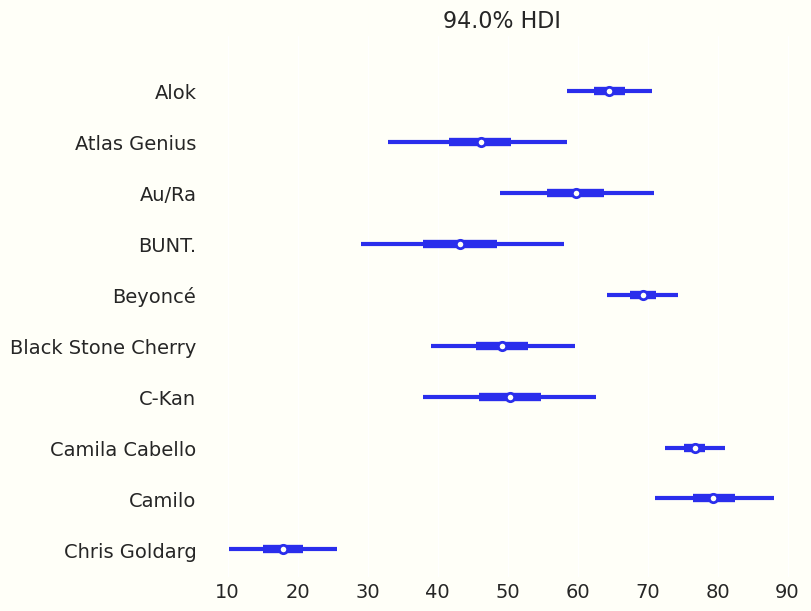

In [30]:
# The forest plot compares HDI intervals from a number of distributions, in our example 
# referring to the posterior mean of different artists.
#The posterior mean is estimated more confidently (shorter interval) for artists which have published more songs.

##Code hacks.
#chiedere MF
#We show only the first 10 artists: we limit and label the graph using the coords option. 
#combined=True implies that we get a single plot for each artist,  merging  samples from different chains.

axes = az.plot_forest (trace_unpooled,
                       var_names="mu_artist",
                       combined=True,
                       coords={"mu_artist_dim_0": range(10)},
                       figsize=(8, 6))
artists_10 = artists[:10]
axes[0].set_yticklabels(artists_10[::-1]);

#artists_10

# Discussion

The no pooled model represents the diversity between  artists with two shortcomings:

* estimates for artists with few songs are  uncertain
    
* it  does not model the *population* of  artists. Even though we have analyzed 44 artist, we are unable to say anything about a  Spotify artist not yet present in the sample.

In [32]:
#predictive distribution for Beyonce and BULK., implemented in Pymc3

with pm.Model() as unpooled_model_with_preds:
    
    #lines below as in the unpooled model 
    mu_artist         =  pm.Normal ('mu_artist', 50,  20, shape= n_artist)
    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 30)
    popularity         =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = global_sigma, observed = spotify["popularity"])
    
    #predictive distribution for specific artists
    pred_beyonce   = pm.Normal ('pred_beyonce', mu = mu_artist[beyonce_code],  sigma = global_sigma)
    pred_bunt          = pm.Normal ('pred_bunt',      mu =  mu_artist[bunt_code],         sigma = global_sigma)
    
    trace_unpooled_with_preds  = pm.sample(return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pred_bunt, pred_beyonce, global_sigma, mu_artist]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [18]:
#Notice the larger uncertainty of predictive distribution, compared to the uncertainty on the posterior mean
az.summary(trace_unpooled_with_preds, var_names=['pred_beyonce', 'pred_bunt'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_beyonce,69.510,14.387,41.598,97.668,0.156,0.117,8524.0,2814.0,1.0
pred_bunt,43.512,16.161,11.706,75.078,0.184,0.150,7729.0,3057.0,1.0


# Discussion

* Posterior mean popularity of Beyonce': 
    * the HDI is between the .025 and .975 percentile of the posterior samples of $\mu[beyonce]$
    

* Predictive distribution for the next song by Beyonce': 
    * the HDI is between the .025 and .975 percentile of the samples $y^{\text{beyonce, new}}$
    * $y^{\text{beyonce, new}}_s \sim N(\mu[beyonce]_s, \sigma_s)$, where $\sigma$ is the global sigma. 


# Hierarchical model

\begin{equation}
\begin{array}{lrl}
\text{Layer 1:} & \hspace{-0.05in} y_{ij} \sim N( \mu_j, \sigma) & \hspace{-0.075in} \text{how song popularity varies WITHIN artist } j \\
\text{Layer 2:} & \hspace{-0.05in} \mu_j \sim N( \mu, \sigma_\mu) & \hspace{-0.075in}  \text{population of artists:  how  $\mu_j$ varies BETWEEN artists}\\
\text{Layer 3:} & \hspace{-0.05in} \text{densities for } \mu, \sigma, \sigma_\mu  & \hspace{-0.075in} \sim \text{prior  for shared  parameters} \\
\end{array}
\end{equation}

# Individual songs for each artist.

* As in the unpooled model, we assume that the popularity of songs  of  artist $j$ to be  $N(μ_j,σ)$:

$$  y_{ij} \sim N(\mu_j, \sigma) $$


*  $σ$ is the global sigma, which is equal for  all artists.

# Population of artists



* The 44 $\mu_j$'s  are samples  from the population of Spotify artists:


$$ \mu_j \sim N(\mu', \sigma_{\mu}) $$

* $\mu'$: mean popularity in the population of the Spotify artists
* $\sigma_{\mu}$: spread between the  popularity of the different artists

# Modeling the population of artists

$$ \mu_j \sim N(\mu', \sigma_{\mu}) $$


* We want to learn the population of artists, and hence both $\mu'$ and $\sigma_{\mu}$ are  *parameters*, to which we need to assign a prior.

# Notation alert

*  $μ_j$: mean popularity of songs from  the j-th artist)
* $\mu'$: mean value of $\mu_j$, if we consider the whole  population of artists (not only those in our sample).


* $\sigma$:  standard deviation of popularity between songs from the same author. 
* $\sigma_{\mu}$ standard deviation of the $\mu_j$ within the population of artists.

# Priors for the population of artists: $\mu', \sigma_{\mu}$

\begin{align*}
\mu'           & \sim N(50, 20) && \text{(50 +- 40)} \\
\sigma_\mu & \sim \text{Half Normal}(6)    && \text{spread betweent the different mu_j : next slide}  \\
\end{align*}

In [19]:
# how to choose the priors on sigma_mu
# We assume the various mu_j  to vary in 0,100; hence a plausible sigma_mu is 15 (the HN has a long right tail anyway)
pd.DataFrame(np.abs(np.random.normal(0, scale=22, size=10000))).describe(percentiles=[0.50, 0.75, 0.95])

,0
count,10000.000000
mean,17.522318
std,13.409309
min,0.002317
50%,14.572239
75%,25.321668
95%,43.545521
max,89.381393


In [20]:
n_artist = len(artist_count) #44

with pm.Model() as hier_model:
    
    # layer 1: prior on the parameters of the population of artists (hyper-priors). 
    
    # prior beliefs about the mean value and the spread of the different mu_j
    mu_pop         = pm.Normal ('mu_pop', 50,  20)
    sigma_mu     = pm.HalfNormal ('sigma_mu', 22)
    
    
    # layer 2: each artist is a sample from the population of artists; we sample n_artist times from such population.
    mu_artist        =  pm.Normal ('mu_artist', mu=mu_pop, sigma=sigma_mu, shape= n_artist)
    
    # global_sigma (spread between songs of the same authors) is as in the unpooled model.
    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 30)

    #Popularity of each song is a sample from N(mu_j, global_sigma).
    popularity    =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = global_sigma, observed = spotify["popularity"])
    
    trace_hier    = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, mu_artist, sigma_mu, mu_pop]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


# Parameters
* The hierarchical Spotify model  has  47 parameters:
    * 44 artist-specific parameters $\mu_j$
    * 2 parameters for the population of artists: $\mu',   \sigma_{\mu}$.
    * the global sigma $\sigma$

In [21]:
#mu_pop is indeed close to 50 as we assumed, with a tight HDI
az.summary(trace_hier, var_names=["mu_pop", "sigma_mu", "global_sigma", "mu_artist"])[["mean","hdi_3%","hdi_97%","r_hat"]].head()

,mean,hdi_3%,hdi_97%,r_hat
mu_pop,52.459,47.694,57.039,1.0
sigma_mu,15.172,11.751,18.813,1.0
global_sigma,14.036,13.022,15.064,1.0
mu_artist[0],64.332,58.187,69.937,1.0
mu_artist[1],46.914,35.410,58.794,1.0


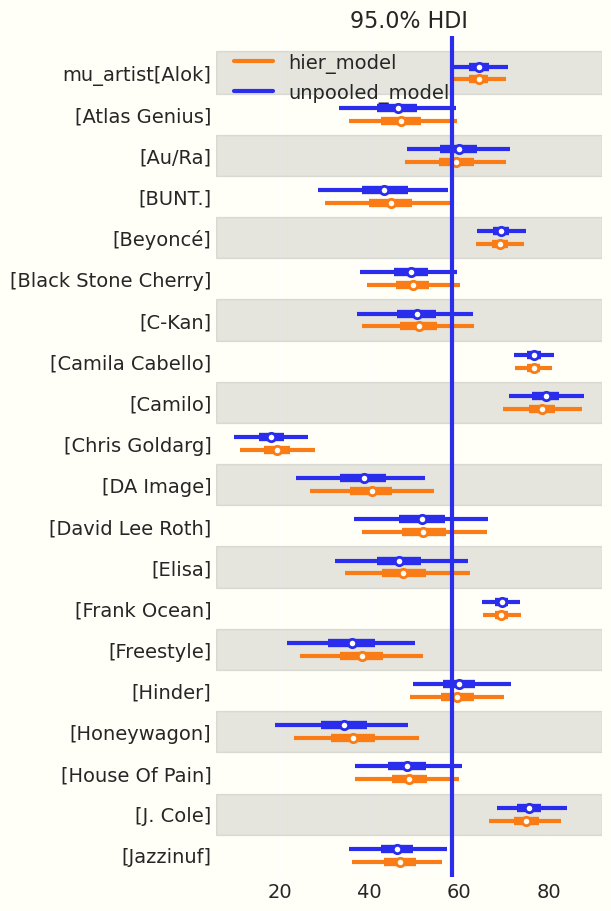

In [22]:
#estimated mean popularity of each artist, according to the unpooled and to the hierarhical model
# the estimates of the hierarchical model are closer to mean popularity of all songs in the sample.

trace_unpooled_ = trace_unpooled.copy() # just to avoid touching the existing objects
trace_unpooled_.posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)
trace_hier_ = trace_hier.copy()
trace_hier_.posterior = trace_hier.posterior.assign_coords(mu_artist_dim_0=artists)

axes = az.plot_forest([trace_unpooled_, trace_hier_], 
                      model_names=['unpooled_model', 'hier_model'], combined=True,
                      var_names='mu_artist', hdi_prob=0.95, coords={"mu_artist_dim_0": artists[0:20]});
 
#mean popularity of all songs
grand_mean = spotify["popularity"].mean()
axes[0].axvline(x=grand_mean);

In [37]:
trace_unpooled_.posterior

<xarray.Dataset>
Dimensions:          (chain: 4, draw: 1000, mu_artist_dim_0: 44)
Coordinates:
  * chain            (chain) int64 0 1 2 3
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * mu_artist_dim_0  (mu_artist_dim_0) <U18 'Alok' ... 'Zeds Dead'
Data variables:
    mu_artist        (chain, draw, mu_artist_dim_0) float64 61.35 58.7 ... 49.08
    global_sigma     (chain, draw) float64 14.09 13.88 13.82 ... 13.54 14.87
Attributes:
    created_at:                 2022-11-10T12:37:06.464280
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.5
    sampling_time:              21.460664749145508
    tuning_steps:               1000

In [39]:
az.summary(trace_unpooled_, var_names='mu_artist[Alok]')

KeyError: 'var names: "[\'mu_artist[Alok]\'] are not present" in dataset'

# Shrinkage: pulling the estimates towards the grand mean

*  The pooled  model ignores the fact that our data is grouped by artist;  the  posterior mean popularity was the same for each artist   (grand mean), roughly corresponding to the mean popularity of the 350 available songs.


*  The unpooled model separately analyzes each artist;  its predictive means are roughly equivalent to the sample mean popularity of  each artist. It does not use the grand mean.


* The hierarchical model pulls  (or *shrunk*) the posterior means of the unpooled model  toward the grand mean.


# Shrinkage == arrivato qui

* It the variances $\sigma^2$ and  $\sigma^2_{\mu}$ are fixed, the posterior mean computed by the hierarchical model for  artist $j$  is: 

$$
\overline{y}_{j,\text{hier}} =
\underbrace{
\frac{\sigma^2}{\sigma^2 + n_j \sigma^2_{\mu}}
}_{\text{weight of the grand mean}}
\overline{y}_{\text{global}} + 
\underbrace{
\frac{n_j\sigma^2_{\mu}}{\sigma^2+ n_j \sigma^2_{\mu}}
}_{\text{weight of the estimate of the unpooled model}}
\overline{y}_j
$$


* This is not our case, as we treat both variances as parameters. Yet, we can use  the above formula to understand *shrinkage*.

* The weight of   local model increases when we have more data ($n_j$) about artist $j$.
* The weights also depend on $\sigma_y$: the larger $\sigma_y$ and hence the variability of popularity for the same artist, the larger the weight of the global model (we cannot trust much the means  $\overline{y}_j$).

# Shrinkage

$$
\overline{y}_{j,\text{hier}} =
\underbrace{
\frac{\sigma^2_y}{\sigma^2_y + n_j \sigma^2_{\mu}}
}_{\text{weight of the global model}}
\overline{y}_{\text{global}} + 
\underbrace{
\frac{n_j\sigma^2_{\mu}}{\sigma^2_y + n_j \sigma^2_{\mu}}
}_{\text{weight of the estimate of the  model}}
\overline{y}_j
$$

* Scenarios in which the hierarchical posterior predictions shrinks towards the global mean:

*  $n_j$ is low:  we rely more on global trends to understand a group for which we have little data.

* the variability of popularity for songs of the same artist ($\sigma_y$) is large in comparison to the variability the mean populatrity of the artists $\sigma_{\mu}$.

*  the models learns that  artist are very similar to each other ($\sigma_{\mu}$ is low), it increases the weight of the pooled model.

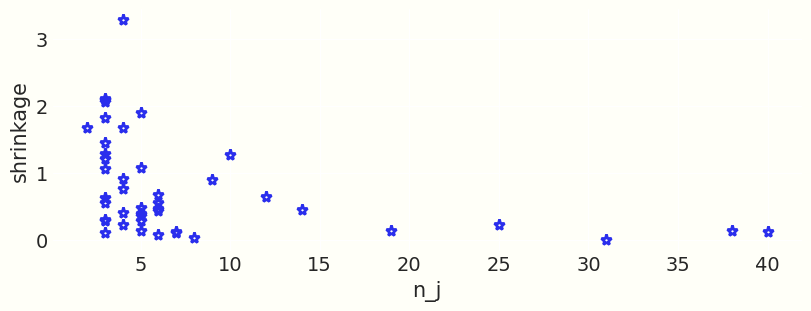

In [23]:
# here we define shrinkage as the difference between the posterior mean of the hierarchical model 
# and the unpooled model, in absolute value.
# We show the amount of shrinkage, in absolute value, as a function of the number of songs for each artist

n_j = spotify['artist'].value_counts(sort=False)
mean_unpooled = az.summary(trace_unpooled, var_names=["mu_artist"])["mean"]
mean_hier = az.summary(trace_hier, var_names=["mu_artist"])["mean"]

#absolute value of the shrinkage
shrinkage = pd.Series((mean_hier-mean_unpooled).values, index=artists).abs()

df = pd.concat([n_j, shrinkage], axis=1)
df.columns = ["n_j", "shrinkage"]
plt.plot(df["n_j"], df["shrinkage"], "*")
plt.xlabel("n_j")
plt.ylabel("shrinkage"); 

# Grouping variable or covariate?

* Suppose our dataset includes a categorical variable  $X$


* Should $X$  be modeled  hierarchically or as a categorical variable (categorical covariate)?

    *   if the observed data on $X$ covers all categories of interest, it is  better treated as a covariate
    
    *  if the observed categories is a random sample from many possible ones, it is a potential grouping variable.


# Grouping variable or covariate?


* Our data set includes only  44 among thousands of artists on Spotify. Hence, treating artist as a covariate (as in the unpooled model) would limit our understanding only to  this small number of artists.


* Treating it as a grouping variable (as in the hierarchical model) allows us to not only learn about the 44 artists in our data, but the broader population of artists from which they were sampled.


# Grouping variable or covariate?

* Consider a daily data set of bike-sharing covering two years; for each day we know whether it was a weekday or a weekend.

* Is the weekend variable a grouping variable or  a covariate?

    * There are only two possible categories: weekend and weekday.
    * The dataset covers both categories, with many observations for each category.
    * Hence  it is a covariate.

# Grouping variable or covariate?

* Consider a data set containing math scores  from a sample of 10 Swiss primary schools. 


* These 10 schools are merely a small sample from the hundreds  of Swiss primary schools.
    * The `school_id`, treated as a covariate (unpooled model) would only allow us to learn about our small sample of schools.
    * Treating it as a grouping variable in a hierarchical model  would allow us to extend our conclusions to the broader population of all schools; this is a better modelling choice.
    
    
* The same consideration applies if you want to analyze e.g. data of a certain disease collected by different hospitals, in which case the involved hospitals can be modelled as a grouping variable.

# Conceptual exercise: modelling fuel prices

* Define a hierarchical model for the fuel price which considers  different stations located in the same area over a period of e.g. one month.


 * Thus $y_{ij}$ is the price of gas at the $j$-th station in the $i$-th day.


*  Discuss the meaning of all model parameters ( $\mu_j$, $\sigma_y$, $\mu$, $\sigma_{\mu}$).


*  Write the probabilistic model defining the priors based on your experience.    

# Discussion

* The pooled model is very rigid  and  miss the nuances in artists’ mean popularity. 


* No pooled models have the opposite problem. With the built-in flexibility to detect group-specific trends, they tend to have less bias than complete pooled models. But, since they’re tailored to the artists in our sample, it cannot produce predictions regarding  a different set of Spotify artists. Moreover, predictions about artists with limited number of songs have large uncertainty,


* Hierarchical models offer a balanced alternative. Unlike complete pooled models, hierarchical models take group-specific trends into account, and thus will be less biased. And unlike no pooled models, hierarchical models take global trends into account, and thus will be less variable. 

# Probabilistic prediction  with the hierarchical model

* Let us consider e.g. artist n. 25.

* Assuming to access the sample of the trace, our prediction about the popularity of the next song by artist 25 is done simulating, for each sample $s$,: 
 $$y_{25,s}^{new} \sim N( \mu_{25,s}, \sigma_{y,s}) $$
 
 * Implement the prediction and check the consistency of the results by:
     * using the samples from the trace
     * implementing the prediction within the pymc3 model

# Probabilistic prediction  with the hierarchical model


* Write a pseudo-code to predict the popularity of the first  song of a novel artist.


* Implement the prediction

In [24]:
# prediction of the popularity of a new song for artist 25 by  accessing the trace

a = az.extract_dataset(trace_hier)
y_new_25 = np.random.normal (loc = a["mu_artist"][25],  scale = a["sigma_y"])
pd.DataFrame(y_new_25).describe(percentiles=[0.03,0.97])

# a very few sampled data are negative. Can you trace the reason of this problem and provide a solution?

KeyError: 'sigma_y'

In [ ]:
n_artist = len(artist_count) #44

with pm.Model() as hier_model_with_preds:
    
    # layer 1: prior on the parameters of the population of artists (hyper-priors). 
    # prior beliefs about the location of the mean popularity within the population of artists
    mu_population          = pm.Normal ('mu_p', 50,  20)
    sigma_mu = pm.HalfNormal ('sigma_mu', 6)
    sigma_y      = pm.HalfNormal ('sigma', 15)

    
    # layer 2: model of the population of artists.
    mu_artist  =  pm.Normal ('mu_artist', mu_population,  sigma_mu, shape= n_artist)
    sigma_y     = pm.HalfNormal ('sigma_y', sd = sigma_y)

    #layer 3 (observation specific for each artist)
    popularity    =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = sigma_y, observed = spotify["popularity"])
    
    # == PREDICTIONS
    #prediction of popularity for the next song of  artist 25
    prediction_artist25 = pm.Normal('prediction_artist25', mu = mu_artist[25],  sigma = sigma_y)
    
    #prediction of popularity for a song from a  novel artist. This requires two steps.
    # step 1:  sample the popularity mu_j of the new artist, by sampling from the population of artists.
    mu_new_artist = pm.Normal('new_mean', mu=mu_population, sigma=sigma_mu)
    # step 2:  sample the popularity of a song using the sampled values mu_j for the unknown artist popularity
    prediction_new_artist = pm.Normal('prediction_new_artist', mu = mu_new_artist,  sigma = sigma_y)
    
    trace_hier_with_preds   = pm.sample(return_inferencedata=True)

In [ ]:
# notice the substamtial uncertainty for the prediction of the new artist
az.summary(trace_hier_with_preds, var_names=['prediction_artist25', 'prediction_new_artist'])

# Conceptual exercise 

* Four friends take a  speed-typing tests. Each person repeat 20 times the typing of a certain word.

* Let $y_{ij}$ be the time it takes friend $j$ to complete test $i$.


1) Formalize  a hierarchical model, discussing  the meaning of all model parameters: ($μ_j, μ, \sigma_y, \sigma_{\mu}$)

    
2) Consider the following scenarios and discuss their effect on the posterior distribution of the parameters:

    * The overall results of the 20 timed tests are remarkably similar among the four friends.
    * Each person is quite consistent in their typing times, but there are big differences from person to person – some tend to type much faster than others.

* For each scenario, indicate whether:
* $ σ_y<σ_μ$. 
* $ σ_y≈σ_μ$. 
* $ σ_y>σ_μ$. 